Making large language models (LLMs) open source greatly enhances the accessibility of AI technology worldwide. While it's improbable, it's not impossible that the next AI breakthrough could originate from someone lacking access to extensively distributed accelerator clusters. Yet, the scenario shifts notably in AI application development, where there's greater flexibility in choosing product development infrastructure. This convergence of CPU availability, scalability, and the genuine open-source licensing of LLMs emerges as a significant facilitator for AI advancement.

This article delves into the captivating endeavor of fine-tuning Gemma, recently unveiled by Google, on Intel Xeon processors utilizing the Hugging Face Supervised Fine-tuning Trainer (SFTTrainer), Intel Extension for PyTorch (IPEX) coupled with Intel Advanced Matrix Extensions (Intel® AMX), and Auto Mixed Precision (AMP) featuring Bfloat16.

Gemma is crafted for responsible AI development, leveraging the same research and technology employed in creating Gemini models.

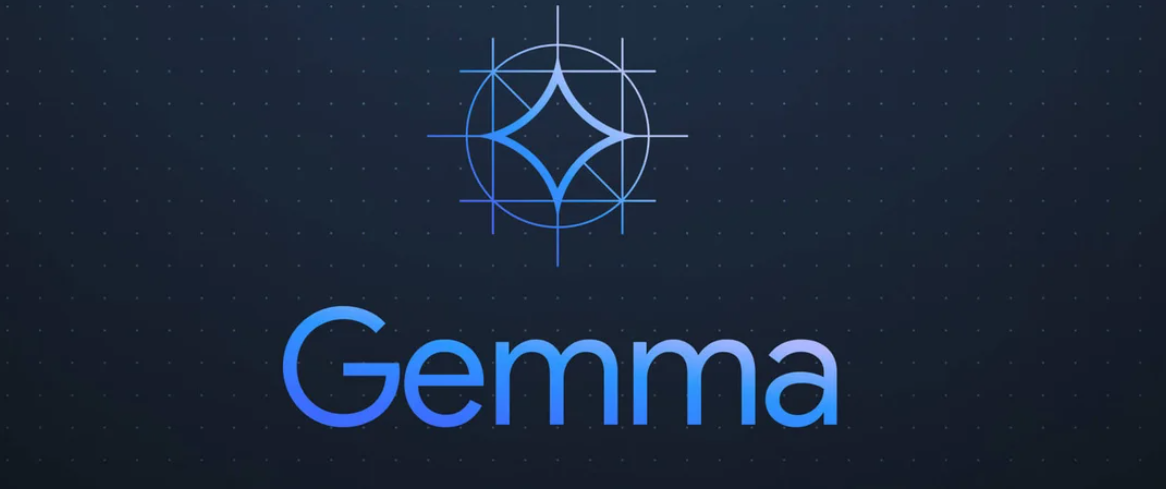

Gemma represents a family of lightweight, cutting-edge open models constructed from the same research and technology as the Gemini models. Developed by Google DeepMind and various teams within Google, Gemma draws inspiration from Gemini, with its name derived from the Latin word "gemma," meaning "precious stone." Alongside releasing model weights, we are also providing tools to encourage developer innovation, foster collaboration, and promote responsible use of Gemma models.

Gemma models share technical and infrastructure elements with Gemini, our most extensive and capable AI model widely accessible today. This commonality enables Gemma 2B and 7B to achieve top-tier performance relative to their sizes compared to other open models. Moreover, Gemma models can run directly on a developer's laptop or desktop computer. Notably, Gemma outperforms significantly larger models on key benchmarks while adhering to our strict standards for safe and responsible outputs.

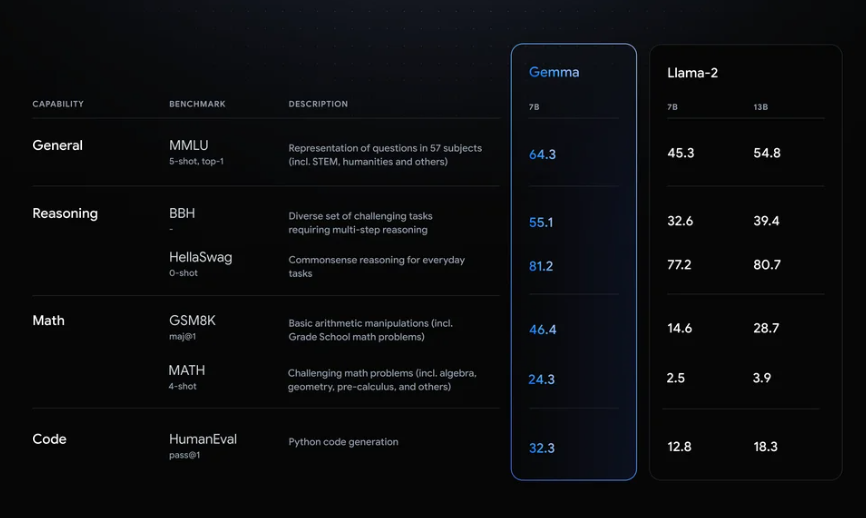

Reference - https://blog.google/technology/developers/gemma-open-models/

Although GPUs have traditionally been the preferred choice for deep learning tasks, fine-tuning Gemma-2B on CPUs offers several advantages:

1. **Availability**: CPUs are widely available and easily accessible, making them an appealing option for researchers and practitioners who may lack access to expensive GPU clusters.

2. **Cost-effectiveness**: CPUs typically offer a more budget-friendly solution than GPUs for large-scale deployments, helping to reduce overall expenses associated with hardware infrastructure.

3. **Compatibility**: CPUs are compatible with a diverse array of hardware and infrastructure, ensuring seamless integration into existing systems without the need for extensive modifications or additional hardware investments.

4. **Scalability**: CPUs provide scalability options that can easily accommodate growing computational demands, allowing for flexible and efficient resource allocation as project requirements evolve.

5. **Versatility**: CPUs are capable of handling a wide range of tasks beyond deep learning, making them a versatile choice for organizations with diverse computing needs. This versatility allows for the utilization of existing hardware for multiple purposes, optimizing resource utilization and minimizing costs.

Combining SFTTrainer with IPEX featuring Intel AMX and AMP with Bfloat16 enhances the efficiency and effectiveness of fine-tuning Gemma-2B. SFTTrainer streamlines the fine-tuning process by offering a higher-level abstraction for intricate tasks. Meanwhile, IPEX and AMP leverage the latest hardware capabilities in Intel Xeon processors. This extension integrates support for cutting-edge optimizations and devices ahead of their incorporation into open-source PyTorch. Additionally, it facilitates AMP training and inference, converting parameters and operations to Bfloat16 to accelerate Intel AMX while maintaining full 32-bit accuracy when necessary.

Let's start first by installing all the necessary packages. Do make sure that the torch and intel_extension_for_pytorch has the same version. It's 2.0 here

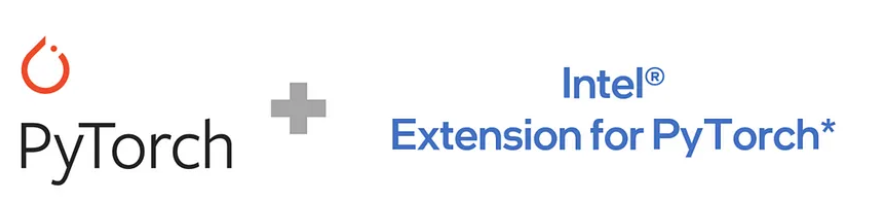

In [ ]:
!pip install torch==2.0.1
!pip install transformers
!pip install bitsandbytes
!pip install peft
!pip install accelerate
!pip install datasets
!pip install trl
!pip install einops
!pip install scipy
!pip install intel_extension_for_pytorch==2.0.100

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Prior to executing the script, it is crucial to set the following environment variable to ensure the selection of the Intel AMX ISA.

In [ ]:
!export ONEDNN_MAX_CPU_ISA="AVX512_CORE_AMX"

Gemma is a gated model. One need to accept the terms and conditions before using it for fine-tuning. https://huggingface.co/google/gemma-2b Following line of code will help us to login to huggingface_hub using your HF_TOKEN

In [ ]:
from huggingface_hub import login
login("HF_TOKEN")

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/ud4844b04070f88292f4c0cb81f4e211/.cache/huggingface/token
Login successful


We will utilize the Farmers Call Query Data from Kaggle, generated using information sourced from data.gov.in, an open data platform provided by the Government of India. This dataset pertains to the Kisan Call Centre, where farmers phoned in with queries, and experts provided responses.

In [ ]:
import time
from datasets import load_dataset
from trl import SFTTrainer
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments)

file_path = "questionsv4.csv"
dataset = load_dataset("csv", data_files={file_path})
model_name = "google/gemma-2b"

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Before starting the fine-tuning process, we would convert the model to Instructions, Input and Response Format

In [ ]:
prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def formatting_prompts_func(examples):

    inputs = [" " for i in range(len(dataset['train']['questions']))]
    print(len(inputs))
    EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

    instructions = examples["questions"]
    inputs       = inputs
    outputs      = examples["answers"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, output) + EOS_TOKEN
        #print(text)
        texts.append(text)
    return { "text" : texts}
pass

from datasets import load_dataset
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

1000


The runs would be saved in the output_dir. We make use we set the use_ipex and bf16 to True. Bfloat16 (BF16) aids in enabling mixed precision training, while IPEX is utilized to regulate the maximum length of the generated text in text generation tasks.

The `use_ipex` argument in `TrainingArguments` from the Hugging Face Transformers library controls whether to **leverage Intel® Extension for PyTorch (IPEX)** during training. Here's a breakdown:

* **Purpose:** IPEX is a library built on top of PyTorch that provides optimizations for CPU training, particularly on Intel processors. It utilizes advanced instruction sets like AVX512-VNNI and AMX to accelerate matrix operations crucial in deep learning.
* **Activation:** Setting `use_ipex` to `True` enables IPEX if it's installed and compatible with your system. Combining it with `bf16=True` further activates mixed precision training with 16-bit floating-point numbers (bf16) for faster training while maintaining accuracy.
* **Benefits:** When used on compatible Intel CPUs, `use_ipex` can significantly improve training speed compared to standard PyTorch execution. It's especially beneficial for large models or extensive training runs.
* **Important Note:** IPEX requires separate installation and may not be available on all systems, particularly those with non-Intel CPUs or older Intel CPUs lacking AVX512 support. Always check compatibility before enabling `use_ipex`.

In [ ]:
training_arguments = TrainingArguments(
        output_dir="./results",
        bf16=True,
        use_ipex=True,
        no_cuda=True,
        fp16_full_eval=False,
    )

/home/ud4844b04070f88292f4c0cb81f4e211/.local/lib/python3.9/site-packages/transformers/training_args.py:1376: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


The SFT Trainer from Hugging Face is designed for efficient fine-tuning of large models with smaller datasets. It simplifies training by offering a streamlined interface and memory-saving techniques. To use it, you'll provide your model, training arguments like learning rate and epochs, and your training data.

You can set _packing_ to be true here. The _packing_ argument in SFT Trainer enables example packing. This means it combines multiple short examples into a single, longer input sequence for training. This improves training efficiency by reducing the number of forward passes needed.

In [ ]:
trainer = SFTTrainer(
        model=model,
        train_dataset=dataset["train"],
        dataset_text_field="text",
        max_seq_length=512,
        tokenizer=tokenizer,
        args=training_arguments,
        packing=True,
    )

Generating train split: 0 examples [00:00, ? examples/s]

/home/ud4844b04070f88292f4c0cb81f4e211/.local/lib/python3.9/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
/opt/intel/oneapi/intelpython/envs/pytorch-gpu/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can e

We train it for 3 epochs. It takes around 15 mins approximately for dataset with 1000 Query Resonse pairs.

In [ ]:
trainer.train()

/home/ud4844b04070f88292f4c0cb81f4e211/.local/lib/python3.9/site-packages/intel_extension_for_pytorch/frontend.py:500: UserWarning: IPEX CPU does not support fused/fused split update for <class 'torch.optim.adamw.AdamW'> will use non-fused master weight update for bf16 training on CPU.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=57, training_loss=0.7945276896158854, metrics={'train_runtime': 874.5503, 'train_samples_per_second': 0.511, 'train_steps_per_second': 0.065, 'total_flos': 3441435862892544.0, 'train_loss': 0.7945276896158854, 'epoch': 3.0})

The `trainer.model.save_pretrained` function, though not directly present in the `Trainer` class from Hugging Face, offers a convenient way to save your trained model and related files. Here's a breakdown:

1. **Functionality:** It delegates the saving process to the underlying model's `save_pretrained` method. This ensures proper saving of the model's weights and other necessary information, specific to its architecture.

2. **Location:** You specify the desired location (`output_dir`) where the model files will be saved. This directory will typically contain the model weights, tokenizer configuration (if applicable), and training arguments.

3. **Usage:** While `trainer.model.save_pretrained` might not be explicitly defined, you can achieve the same by directly calling `model.save_pretrained(output_dir)`. This works because the `Trainer` class often holds a reference to the trained model (`model`) attribute.


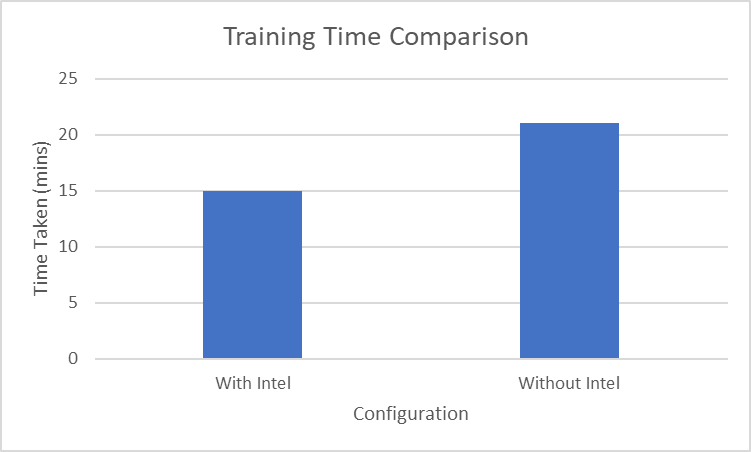

In [ ]:
new_model = "finetuned-gemma"
trainer.model.save_pretrained(new_model)

**With our model successfully fine-tuned, we can assess its performance by testing it with a sample prompt using the provided script to generate a Hugging Face pipeline.**

We load the trained model and load the same tokenizer that of the original model

In [ ]:
import transformers
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_path = "finetuned-gemma"
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b", trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

generator = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16,
        trust_remote_code=True,
        device_map="auto",
    )


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import time

user_input = "start"

while user_input != "stop":

    user_input = input(f"Provide Input to tuned Gemma: ")

    start = time.time()

    if user_input != "stop":
        sequences = generator(
        f""" {user_input}""",
        max_length=200,
        do_sample=False,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,)

    inference_time = time.time() - start

    for seq in sequences:
        print(f"Result: {seq['generated_text']}")

    print(f'Total Inference Time: {inference_time} seconds')
    print("#"*50)

Provide Input to tuned Gemma:  what chemical seed treatment of maize should be done against seed borne  diseases attack?


Result:  what chemical seed treatment of maize should be done against seed borne  diseases attack?

### Input:
 

### Response:
suggested to apply mancozeb@2.5 gram/litre of water.
Total Inference Time: 3.5496528148651123 seconds
##################################################


Provide Input to tuned Gemma:  What are the fertilizer dose and spacing of papaya?


Result:  What are the fertilizer dose and spacing of papaya?

### Input:
 

### Response:
suggested to apply urea 14 kg, 33 kg ssp, 8 kg mop and 2 quintal fym per bigha. urea, ssp and mop should be applied in two equal split doses (march-april and september-october) in the trench method. a trench of 100 cm width and 30 cm depth is suggested and at a radius of 1-1.75 metre  away from the main trunk.
Total Inference Time: 12.941940546035767 seconds
##################################################


We can see that the model can answer questions to the queries on which it was trained. The original model didn't had any such info. When ask the same questions to gemma-2b original, the model starts Hallucinations. 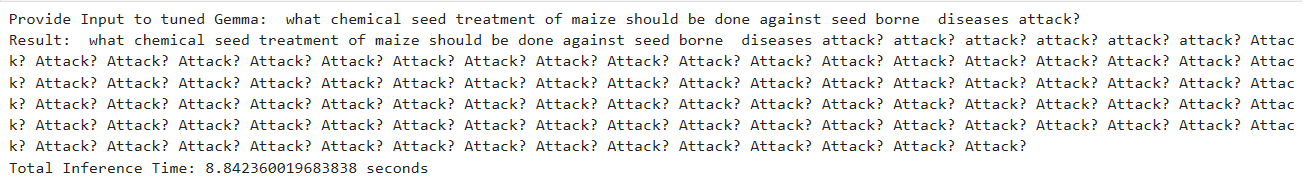

We now possess a fine-tuned iteration of one of the most potent "truly open-source" LLMs ever unveiled! The convergence of Hugging Face's APIs, Intel's accelerated AI tooling, CPU hardware accessibility, and Google's open-source licensing renders this implementation a viable choice for diverse enterprises and AI developers.

Further optimization avenues include hyperparameter tuning, training for more epochs, integration of the Intel® Extension for Transformers, utilization of Intel® Neural Compressor, Parameter-Efficient Fine-tuning (PEFT), Low-Rank Adaptions of LLMs (LoRA), and fine-tuning Intel on the Habana Gaudi*-1 and Gaudi-2 accelerators to enhance training performance.